# Mouse line analysis

In [2]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [3]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [4]:
analysis_type = 'main'  # Analysis type
mouseline = 'sst'  # mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False
do_nonstat_correct = True

### Derived parameters

In [5]:
# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 26/05/2023 09:12:39: assembling batch analysis settings...
 26/05/2023 09:12:39: sst main analysis notebook started on 2023-05-26 at 09:12:39


### Input summary table figure

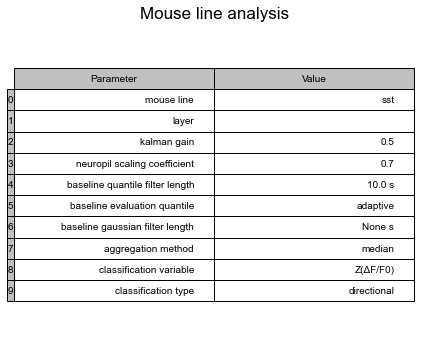

In [6]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 25/05/2023 17:46:02: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/line3:
 25/05/2023 17:46:02: loading mouse-region data from 20190704_mouse2_region1.h5
 25/05/2023 17:46:03: loading mouse-region data from 20190704_mouse3_region1.h5
 25/05/2023 17:46:04: loading mouse-region data from 20190707_mouse1_region1.h5
 25/05/2023 17:46:04: loading mouse-region data from 20190807_mouse5_region1.h5
 25/05/2023 17:46:04: loading mouse-region data from 20190807_mouse6_region1.h5
 25/05/2023 17:46:05: loading mouse-region data from 20190829_mouse10_region1.h5
 25/05/2023 17:46:05: loading mouse-region data from 20191022_mouse1_region1.h5
 25/05/2023 17:46:06: loading mouse-region data from 20191023_mouse3_region1.h5
 25/05/2023 17:46:06: loading mouse-region data from 20191023_mouse10_region1.h5
 25/05/2023 17:46:06: loading mouse-reg

### Unpack data and get ROI counts

In [7]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 25/05/2023 17:47:39: extracting timeseries and stats from data...
 25/05/2023 17:47:41: detailed ROI count:


run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,01,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,,
20190704_mouse2_region1,924,924,923,925,925,925,925,925,925,925,921,925,925,924,925,925
20190704_mouse3_region1,682,682,682,682,682,680,680,682,681,682,680,680,676,680,682,682
20190707_mouse1_region1,480,480,480,480,480,480,nan,480,480,480,480,480,480,480,480,480
20190807_mouse5_region1,488,488,488,488,487,487,nan,488,487,487,488,488,487,488,488,488
20190807_mouse6_region1,952,952,952,952,951,952,nan,nan,950,nan,nan,nan,nan,950,951,949
20190829_mouse10_region1,765,765,765,765,765,765,nan,765,nan,765,765,765,765,765,765,765
20191022_mouse1_region1,386,387,387,385,386,386,nan,386,387,386,386,387,385,385,387,387


### Inspect cell maps and exclude outlier datasets 

 25/05/2023 17:47:42: sorted cell densities:
20191023_mouse3_region1             298.898492
20191107_mouse1_region2             444.896103
20191023_mouse10_region1            697.802225
20191113_mouse9_region2             925.226410
20191228_mouse13_region1            977.711592
20191113_mouse9_region1            1271.694172
20191112_mouse12_region2_layer5    1511.859325
20191022_mouse1_region1            1525.703170
20191230_mouse13_region1           1669.344671
20191112_mouse12_region1           1767.773012
20190707_mouse1_region1            1889.824156
20190807_mouse5_region1            1921.321225
20191024_mouse5_region1            2038.213278
20191109_mouse7_region3_layer5     2161.486378
20191110_mouse10_region1           2480.394205
20200612_mouse13_region1           2645.340638
20190704_mouse3_region1            2685.125155
20200313_mouse14_region1           2763.612201
20191110_mouse6_region1_layer5     2775.679229
20191108_mouse6_region2            2988.284446
20190829_mouse1

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]

 25/05/2023 17:47:50: excluding the following datasets from analysis:
 - 20191228_mouse13_region1
 - 20191107_mouse1_region2
 - 20191023_mouse3_region1
 - 20191023_mouse10_region1
 - 20191113_mouse9_region2
 - 20191113_mouse9_region1
 25/05/2023 17:47:50: 21 datasets remaining


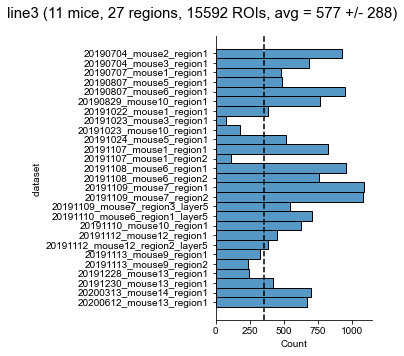

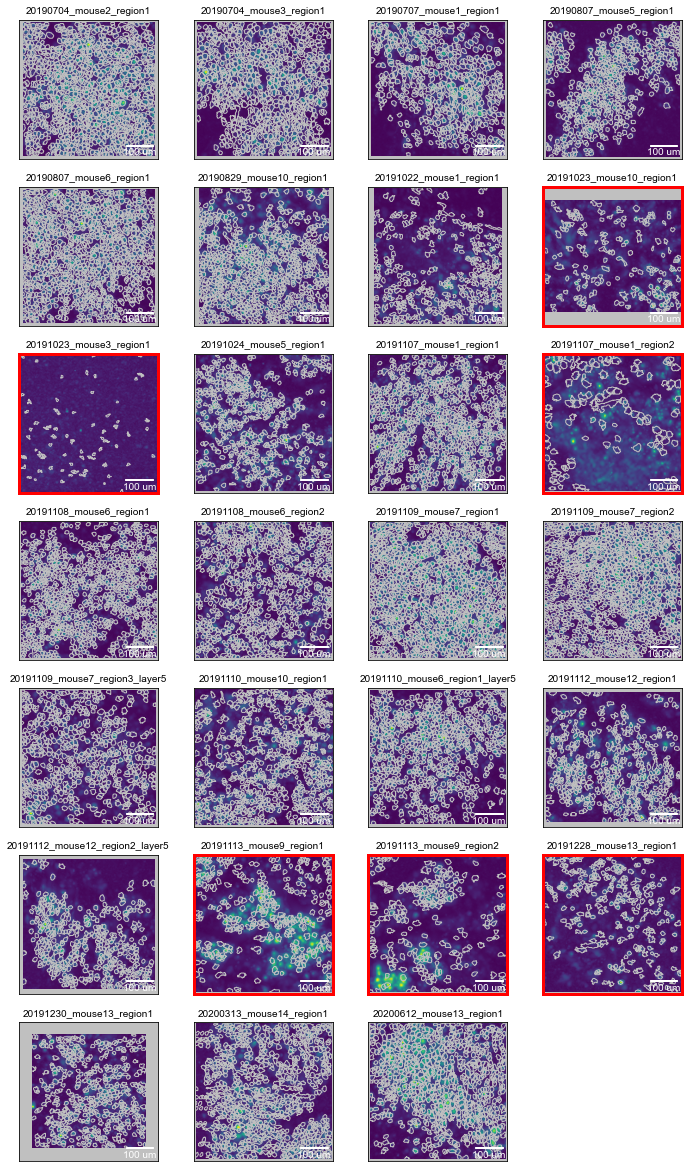

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue=None, 
    outliers=outliers)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=outliers)

### Inspect baseline variation throughout experiments

 25/05/2023 17:47:56: inspecting relative variations in baseline fluorescence across experiments...
 25/05/2023 17:47:56: maximal relative FO deviations:
dataset
20190807_mouse6_region1            0.027337
20190704_mouse3_region1            0.029069
20200612_mouse13_region1           0.038580
20200313_mouse14_region1           0.046822
20190807_mouse5_region1            0.050955
20191108_mouse6_region2            0.053566
20191230_mouse13_region1           0.056781
20190704_mouse2_region1            0.056786
20191112_mouse12_region1           0.057512
20190707_mouse1_region1            0.057697
20191110_mouse6_region1_layer5     0.061136
20191024_mouse5_region1            0.064136
20191108_mouse6_region1            0.067514
20191022_mouse1_region1            0.068064
20191109_mouse7_region1            0.069781
20190829_mouse10_region1           0.071061
20191109_mouse7_region2            0.079853
20191107_mouse1_region1            0.080730
20191110_mouse10_region1           0.136699
20

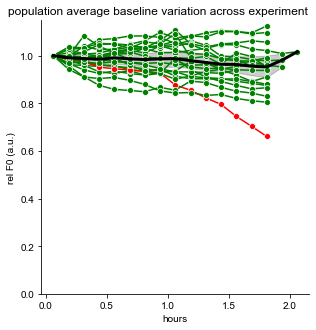

In [9]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    ci=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Inspect run presentation order per dataset and potential consequences on evoked activity

 25/05/2023 17:48:00: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 25/05/2023 17:48:00: run ID not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 17:48:00: sub-indexing data...
 25/05/2023 17:48:00: filtering data...
 25/05/2023 17:48:00: cross-checking filters...
 25/05/2023 17:48:00: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 25/05/2023 17:48:01: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 25/05/2023 17:48:01: run ID not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 17:48:01: sub-indexing data...
 25/05/2023 17:48:01: filtering data...
 25/05/2023 17:48:01: cross-checking filters...
 25/05/2023 17:48:01: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 25/05/2023 17:48:02: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 25/05/2023 17:48:02: run ID not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 17:48:02: sub-ind

dataset,20190704_mouse2_region1,20190704_mouse3_region1,20190707_mouse1_region1,20190807_mouse5_region1,20190807_mouse6_region1,20190829_mouse10_region1,20191022_mouse1_region1,20191024_mouse5_region1,20191107_mouse1_region1,20191108_mouse6_region1,20191108_mouse6_region2,20191109_mouse7_region1,20191109_mouse7_region2,20191110_mouse10_region1,20191110_mouse6_region1_layer5,20191112_mouse12_region1,20191112_mouse12_region2_layer5,20191230_mouse13_region1,20200313_mouse14_region1,20200612_mouse13_region1
run ID,,,,,,,,,,,,,,,,,,,,
0,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.60MPa_50%DC,0.80MPa_50%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_70%DC,0.80MPa_50%DC
1,0.80MPa_30%DC,0.80MPa_40%DC,0.80MPa_30%DC,NaN,0.40MPa_50%DC,0.80MPa_40%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_60%DC,0.80MPa_80%DC,0.80MPa_60%DC
2,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_40%DC,0.20MPa_50%DC,0.80MPa_30%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_70%DC,0.80MPa_40%DC,0.80MPa_70%DC
3,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_30%DC,0.10MPa_50%DC,0.80MPa_20%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_80%DC,0.80MPa_30%DC,0.80MPa_80%DC
4,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_20%DC,0.05MPa_50%DC,NaN,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_40%DC,0.80MPa_20%DC,0.80MPa_40%DC
5,0.80MPa_01%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_10%DC,0.00MPa_50%DC,0.80MPa_05%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_30%DC,0.80MPa_10%DC,0.80MPa_30%DC
6,0.00MPa_50%DC,0.80MPa_01%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.80MPa_60%DC,0.60MPa_50%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_60%DC,0.80MPa_20%DC,0.80MPa_05%DC,0.80MPa_20%DC
7,0.60MPa_50%DC,0.00MPa_50%DC,0.40MPa_50%DC,0.60MPa_50%DC,0.80MPa_70%DC,0.40MPa_50%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_70%DC,0.80MPa_10%DC,0.60MPa_50%DC,0.80MPa_10%DC
8,0.40MPa_50%DC,0.60MPa_50%DC,0.20MPa_50%DC,0.40MPa_50%DC,0.80MPa_80%DC,0.20MPa_50%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_80%DC,0.80MPa_05%DC,0.40MPa_50%DC,0.80MPa_05%DC


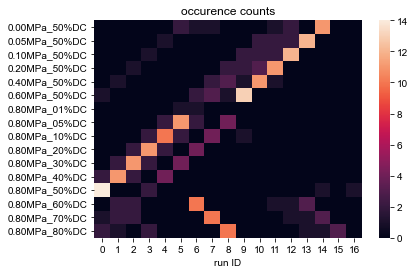

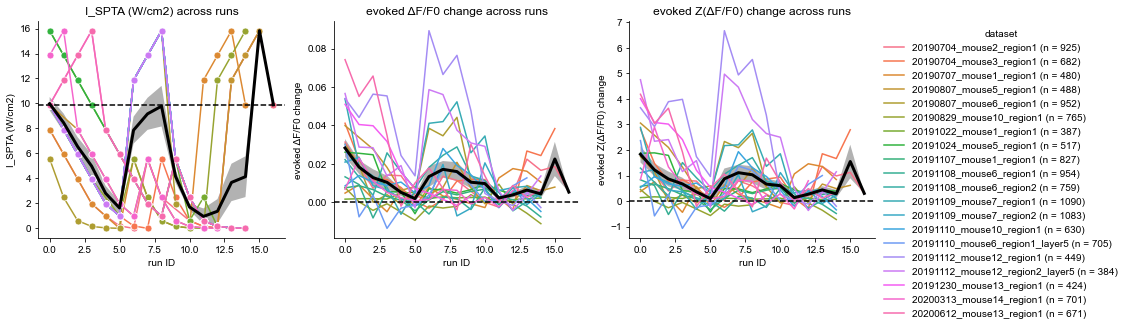

In [10]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
sns.heatmap(data=params_counts, ax=ax)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        ci=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='o' if ykey == Label.ISPTA else None,
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Inspect initial parameter dependency curves

 25/05/2023 18:20:16: adding evoked ΔF/F0 change metrics to stats dataset...
 25/05/2023 18:20:16: applying mean function on ΔF/F0 in [5-10] index window across dataset, ROI, run ...
 25/05/2023 18:20:17: applying mean function on ΔF/F0 in [11-21] index window across dataset, ROI, run ...
 25/05/2023 18:20:18: sub-indexing data...
 25/05/2023 18:20:18: filtering data...
 25/05/2023 18:20:18: cross-checking filters...
 25/05/2023 18:20:18: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 25/05/2023 18:20:18: sub-indexing data...
 25/05/2023 18:20:18: filtering data...
 25/05/2023 18:20:18: cross-checking filters...
 25/05/2023 18:20:18: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 25/05/2023 18:20:19: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 25/05/2023 18:20:19: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 18:20:19: sub-indexing data...
 25/05/2023 18:20:19

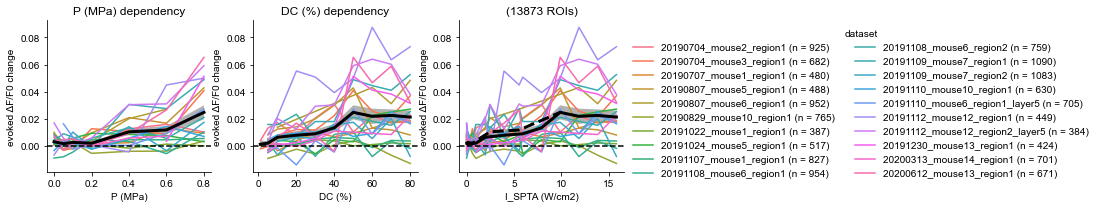

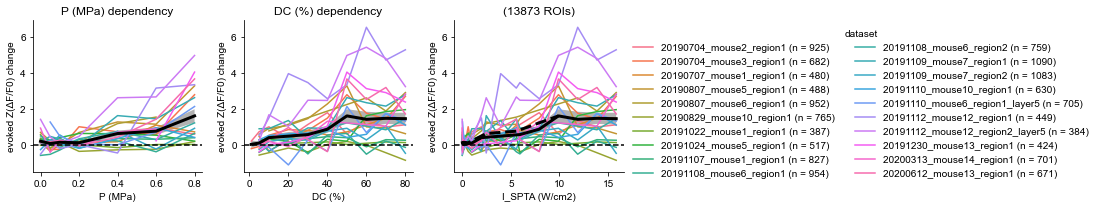

In [18]:
for ykey in [Label.DFF, Label.ZSCORE]:
    ykey_diff = get_change_key(ykey)
    add_change_metrics(trialagg_timeseries, trialagg_stats, ykey, npre=5) 
    figs[f'stimparamdeps {ykey_diff} initial'] = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        ci=None
    )

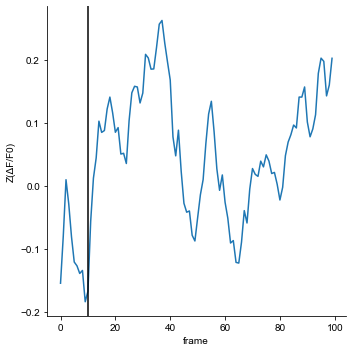

In [15]:
# sns.histplot(
#     data=popagg_timeseries.loc[pd.IndexSlice[:, 0]],
#     y=Label.ZSCORE,
# )

trialagg_timeseries[Label.P] = trialagg_stats[Label.P]
tmp = trialagg_timeseries[trialagg_timeseries[Label.P] == 0]

fg = sns.relplot(
   data=tmp, 
   kind='line',
   x=Label.FRAME,
   y=Label.ZSCORE,
   ci=None,
   # hue=Label.DATASET,
   )
fg.figure.axes[0].axvline(10, c='k')

## Curations & corrections

### Identify and exclude datasets with no parameter dependency

 25/05/2023 16:51:38: computing population average data across (dataset, run, trial)...
 25/05/2023 16:51:39: assessing parameter dependence per dataset with ANOVA...
 25/05/2023 16:51:39: datasets with no parameter dependency:
['20190510_mouse6_region1',
 '20190510_mouse6_region2',
 '20190511_mouse7_region2',
 '20190516_mouse8_region1',
 '20190516_mouse8_region2',
 '20190629_mouse3_region1',
 '20190808_mouse6_region1']
 25/05/2023 16:51:39: excluding the following datasets from analysis:
 - 20190808_mouse6_region1
 - 20190511_mouse7_region2
 - 20190516_mouse8_region1
 - 20190629_mouse3_region1
 - 20190510_mouse6_region1
 - 20190516_mouse8_region2
 - 20190510_mouse6_region2
 25/05/2023 16:51:39: 10 datasets remaining
 25/05/2023 16:51:40: sub-indexing data...
 25/05/2023 16:51:40: filtering data...
 25/05/2023 16:51:40: cross-checking filters...
 25/05/2023 16:51:40: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 25/05/2023 16:51:40: sub-indexing 

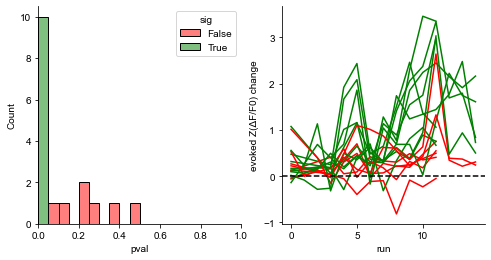

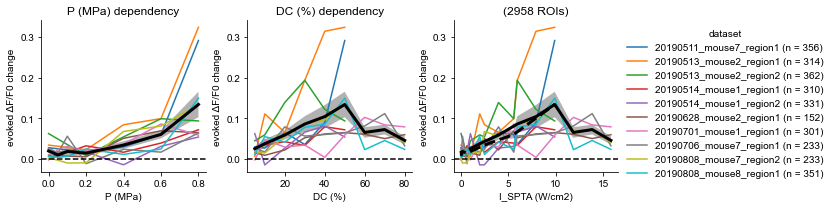

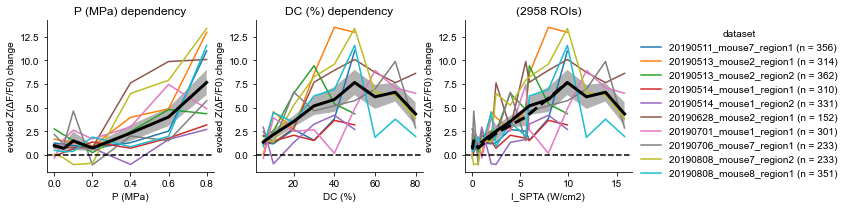

In [12]:
ykey_diff = get_change_key(Label.ZSCORE)

# Compute population-average stats
popagg_stats = get_popavg_data(ext_stats)

# Assess response parameter dependency per dataset with ANOVA
logger.info('assessing parameter dependence per dataset with ANOVA...')
anovares = (
    popagg_stats[ykey_diff]
    .groupby(Label.DATASET)
    .agg(lambda s: compute_1way_anova(s.reset_index(), Label.RUN, ykey_diff))
    .rename('pval')
    .to_frame()
)
anovares['sig'] = anovares['pval'] < PTHR_DETECTION
nonpdeps_datasets = anovares[~anovares['sig']].index.values.tolist()
if len(nonpdeps_datasets) > 0:
    logger.warning(f'datasets with no parameter dependency:\n{pprint.pformat(nonpdeps_datasets)}')

# Create figure backbone
figs['pdep anova analysis'], axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    sns.despine(ax=ax)

# Plot p-value distributions
sns.histplot(
    ax=axes[0],
    data=anovares,
    x='pval',
    binwidth=.05,
    hue='sig',
    palette={True: 'g', False: 'r'}
)
axes[0].set_xlim(0, 1)

# Plot parameter dependencies per dataset, along with ANOVA result color code
sns.lineplot(
    ax=axes[1],
    data=popagg_stats,
    x=Label.RUN,
    y=ykey_diff,
    hue=Label.DATASET,
    palette=get_binary_palette(anovares, nonpdeps_datasets),
    ci=None,
    legend=False
)
axes[1].axhline(0, ls='--', c='k')

if mouseline != 'pv':
    # Exclude datasets with no parameter dependency, and re-plot param dependency curves
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, 
        to_exclude=nonpdeps_datasets
    )
    for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
        figs[f'stimparamdeps {ykey_diff} post anova exclude'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue', 
            ci=None,
        )

### Identify and remove datasets with outlier evoked z-score for P = 0

In [13]:
# ykey_diff = get_change_key(Label.ZSCORE)

# # Compute population-average stats per datasets for baseline run
# popagg_trialagg_stats = get_popavg_data(trialagg_stats)
# popagg_trialagg_stats0 = popagg_trialagg_stats[popagg_trialagg_stats[Label.P] == 0].droplevel(Label.RUN)
# # Identify datasets with outlier evoked z-scores (in any direction)
# zthr = pvalue_to_zscore(PTHR_DETECTION)
# is_P0_outlier = popagg_trialagg_stats0[ykey_diff].abs() > zthr
# P0_outlier_datasets = is_P0_outlier[is_P0_outlier].index.values.tolist()

# if len(P0_outlier_datasets) > 0:
#     P0_outliers_str = '\n'.join([f'  - {x}' for x in P0_outlier_datasets])
#     logger.warning(f'datasets with outlier response to P = 0 condition:\n{pprint.pformat(P0_outlier_datasets)}')

# # Plot parameter dependencies per dataset, along with ANOVA result color code
# figs['P0 zscore outlier detection'], ax = plt.subplots()
# sns.despine(ax=ax)
# fg = sns.lineplot(
#     ax=ax,
#     data=popagg_trialagg_stats,
#     x=Label.P,
#     y=ykey_diff,
#     hue=Label.DATASET,
#     palette=get_binary_palette(popagg_trialagg_stats, P0_outlier_datasets),
#     ci=None,
#     legend=False,
# )
# ax.axhline(0, ls='--', c='k')
# ax.axhspan(-zthr, zthr, fc='silver', ec=None, alpha=0.3)

# # Exclude datasets with no parameter dependency, and re-plot param dependency curves
# trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
#     trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, 
#     to_exclude=P0_outlier_datasets
# )

# for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
#     figs[f'stimparamdeps {ykey_diff} post P0 exclude'] = plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         avgprop='whue', 
#         ci=None,
#     )

### Inspect & correct response stationarity throughout trial sequences

 25/05/2023 16:51:42: computing population average data across (dataset, run, trial)...
 25/05/2023 16:51:42: comparing evoked ΔF/F0 change values in across half sequences...


0it [00:00, ?it/s]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 1.00e-01
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_1 vs. 9_2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.678e-01 U_stat=2.824e+03
10_1 vs. 10_2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.304e-01 U_stat=6.400e+02
11_1 vs. 11_2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.343e-01 U_stat=4.800e+02
12_1 vs. 12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.872e-01 U_stat=9.150e+02
13_1 vs. 13_2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.849e-01 U_stat=8.090e+02
14_1 vs. 14_2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.625e-01 U_stat=5.780e+02
8_1 vs. 8_2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.139e-01 U_stat=3.273e+03
1_1 vs. 1_2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.109e-02 U_stat=3.691e+03
0_1 vs. 0_2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.280e-01 U_stat=3.225e+03
2_1 vs. 2_2: Mann-Whitney-Wilcoxon test two-sided, P_

1it [00:00,  2.96it/s]

4_1 vs. 4_2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.879e-01 U_stat=2.774e+03
5_1 vs. 5_2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.185e-01 U_stat=3.183e+03
6_1 vs. 6_2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.587e-01 U_stat=2.993e+03
7_1 vs. 7_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.642e-02 U_stat=3.811e+03
 25/05/2023 16:51:43: plotting evoked ΔF/F0 change along trial sequences...


 25/05/2023 16:51:47: computing ROI-weighted average of (10 datasets x 797 ROIs x 15 runs x 16 trials) "evoked ΔF/F0 change" series across run ID & trial...
 25/05/2023 16:51:48: adding regression estimates...
 25/05/2023 16:51:50: assessing evoked ΔF/F0 change stationarity, by run ID, with linear regression analysis
 25/05/2023 16:51:50: identified evoked ΔF/F0 change non-stationarity in the following run ID: [ 1  7 10 12 13]


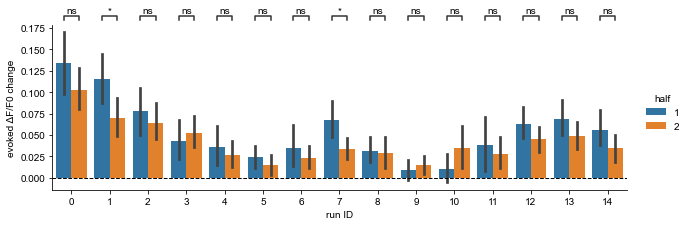

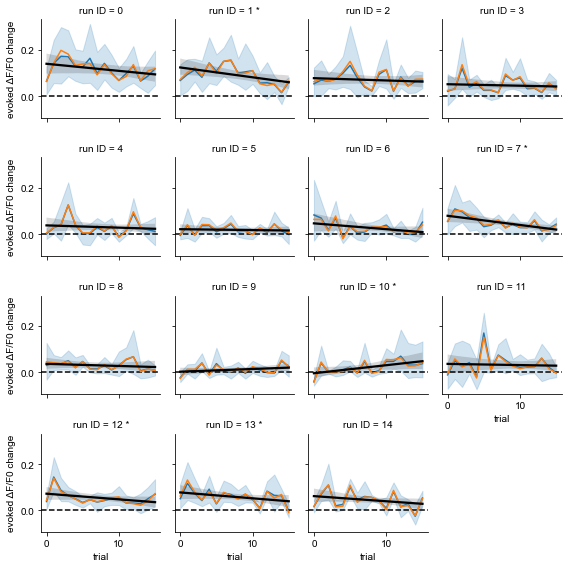

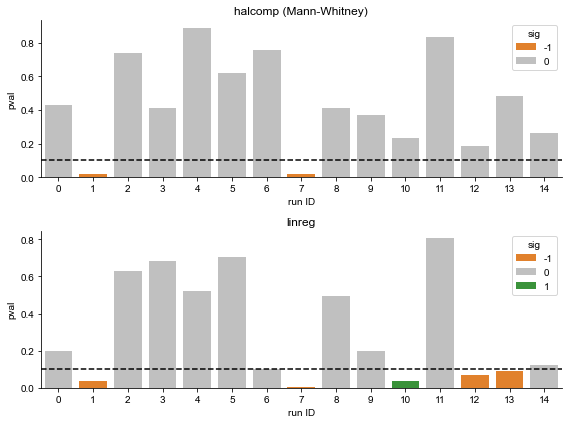

In [14]:
from constants import PTHR_STATIONARITY

# Determine output metrics
ykey_diff = get_change_key(Label.DFF)
stationarity_gby = Label.RUNID  # grouping variable for stationarity analysis

# Compute population-average stats for each trial 
popagg_stats = get_popavg_data(ext_stats)

# Add trial half information
isplit = len(popagg_stats.index.unique(Label.TRIAL)) // 2 - 1
popagg_stats['half'] = popagg_stats.index.get_level_values(Label.TRIAL) <= isplit
popagg_stats['half'] = popagg_stats['half'].map({True: 1, False: 2})

# Evaluate difference between each half distribution statistically
logger.info(f'comparing {ykey_diff} values in across half sequences...')
from scipy.stats import mannwhitneyu, ttest_ind
testtype = 'Mann-Whitney'
# testtype = 't-test_ind'
testfunc = {
    't-test_ind': ttest_ind,
    'Mann-Whitney': mannwhitneyu
}[testtype]
cross_dataset_halfcomp_stats = (
    popagg_stats
    .groupby(stationarity_gby)
    .apply(lambda df: compare_halves(df, ykey_diff, testfunc))
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='diff'))
)

# Plot halves comparison results
pltkwargs = dict(
    data=popagg_stats.reset_index(),
    x=stationarity_gby,
    y=ykey_diff,
    hue='half',
)
fg = sns.catplot(
    kind='bar',
    aspect=3,
    height=3,
    **pltkwargs)
fg.refline(y=0, c='k', lw=1)
annotate_facets(fg, test=testtype, alpha=PTHR_STATIONARITY, **pltkwargs)

# Plot response strength over trial sequence, by grouping variable, 
# with superimposed linear regression estimate
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats,
    col=stationarity_gby,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey=ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata[f'{ykey_diff} - mean'], c='C1')
logger.info('adding regression estimates...')
fg.map_dataframe(
    sns.regplot, 
    scatter=False, 
    color='k', 
    x=Label.TRIAL, 
    y=ykey_diff,
)
figs[f'{ykey_diff} stationarity along trial seq'] = fg.figure

# Perform linear regression on lumped data, by grouping variable, to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by {stationarity_gby}, with linear regression analysis')
cross_dataset_linreg_stats = (popagg_stats
    .groupby(stationarity_gby)
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)

# Plot stationarity p-value for each group
stationarity_measures = {
    f'halcomp ({testtype})': cross_dataset_halfcomp_stats,
    'linreg': cross_dataset_linreg_stats
}
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'], axes = plt.subplots(2, 1, figsize=(8, 6))
for ax, (k, resdata) in zip(axes, stationarity_measures.items()):
    sns.despine(ax=ax)
    sns.barplot(
        ax=ax,
        data=resdata.reset_index(),
        x=stationarity_gby,
        y='pval',
        hue='sig',
        palette=Palette.TERNARY,
        dodge=False,
    )
    ax.set_title(k)
    ax.axhline(PTHR_STATIONARITY, ls='--', c='k')
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'].tight_layout()

# Identify and mark groups with non-stationarity in response strength
non_stationary_groups = cross_dataset_linreg_stats[cross_dataset_linreg_stats['sig'] != 0].index.values
if len(non_stationary_groups) > 0:
    logger.warning(f'identified {ykey_diff} non-stationarity in the following {stationarity_gby}: {non_stationary_groups}')
    for k in non_stationary_groups:
        fg.axes_dict[k].set_title(f'{fg.axes_dict[k].get_title()} *', fontsize=10)
else:
    logger.info(f'no significant {ykey_diff} non-stationarity identified')


# Trick: restrict non-stationary groups to first zero
if stationarity_gby == Label.RUNID:
    non_stationary_groups = list(set(non_stationary_groups).intersection([0]))

# For each non-stationary group
if do_nonstat_correct and len(non_stationary_groups) > 0:
    for group_id in non_stationary_groups:

        # Extract detailed stats for that group
        logger.info(f'extracting detailed stats for {stationarity_gby} {group_id}...')
        if stationarity_gby in ext_stats.index.names:
            detailed_stats_group = ext_stats[ext_stats.index.get_level_values(stationarity_gby) == group_id]
        else:
            detailed_stats_group = ext_stats[ext_stats[stationarity_gby] == group_id]

        # Extract last trial index for each ROI
        logger.info('extracting last trial index for each ROI...')
        last_trial_idx = (detailed_stats_group.iloc[:, 0]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .agg(lambda s: s.index[-1][-1])
        )

        # Perform independent linear regression for each ROI, over trial sequence
        logger.info(f'performing {ykey_diff} linear regression independently on each ROI...')
        linreg_stats_per_roi = (detailed_stats_group[ykey_diff]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .apply(apply_linregress)
            .unstack()
        )

        # Compute project response at last trial from linear regression results
        logger.info(f'projecting {ykey_diff} values from linear regression results...')
        ydiff_proj = linreg_stats_per_roi['slope'] * last_trial_idx + linreg_stats_per_roi['intercept']

        # Compute ratios between trial-aggregated and projected responses
        logger.info(f'computing ratios between trialagg {ykey_diff} values and their lin-reg projected values...')
        ratios = ydiff_proj / trialagg_stats.loc[ydiff_proj.index, ykey_diff]

        # Replace trial-aggregated response values by projected responses values 
        logger.info(f'replacing trialagg {ykey_diff} values by their lin-reg projected values...')
        trialagg_stats.loc[ydiff_proj.index, ykey_diff] = ydiff_proj

        # Use computed ratios to rescale z-scores as well
        zkey_diff = get_change_key(Label.ZSCORE)
        logger.info(f're-scaling trialagg {zkey_diff} values according to {ykey_diff} ratios...')
        trialagg_stats.loc[ydiff_proj.index, zkey_diff] *= ratios
    
        # Re-assess responses
        zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
        trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
            trialagg_stats[get_change_key(Label.ZSCORE)], zthr, directional=directional)
    
    # Re-classify responders
    roistats = classify_ROIs(trialagg_stats)
    for k in roistats:
        trialagg_stats[k] = roistats[k]

    # Re-plot parameter dependency curves
    for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
        figs[f'{ykey_diff} stimparamdeps post global stationary correct'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue',
            ci=None,
        )
    
    do_nonstat_correct = False

## Results visualization

### Plot evoked change distribution for control condition (P = 0)

 25/05/2023 16:51:51: response type proportions at P = 0:
weak        71.403873
positive    28.596127
Name: response type, dtype: float64


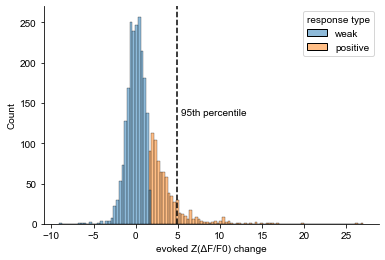

In [15]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot parameter dependency curves

 25/05/2023 16:51:52: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 16:51:52: plotting ΔF/F0 stimulation parameters dependencies...
 25/05/2023 16:51:52: sub-indexing data...
 25/05/2023 16:51:52: filtering data...
 25/05/2023 16:51:52: cross-checking filters...
 25/05/2023 16:51:52: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 25/05/2023 16:51:52: sub-indexing data...
 25/05/2023 16:51:52: filtering data...
 25/05/2023 16:51:52: cross-checking filters...
 25/05/2023 16:51:52: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 25/05/2023 16:51:52: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 25/05/2023 16:51:52: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 16:51:52: sub-indexing data...
 25/05/2023 16:51:52: filtering data...
 25/05/2023 16:51:52: cross-checking filters...
 25/05/2023 16:51:52: grouping by dataset, averaging and plotti

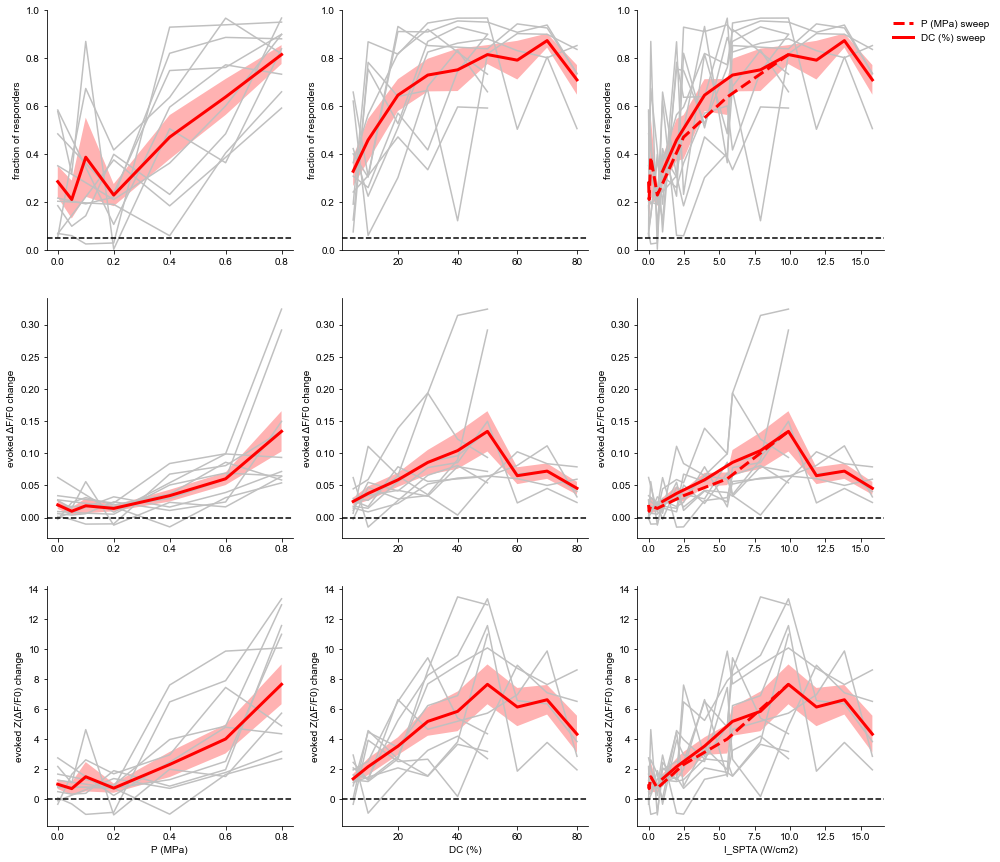

In [16]:
figs['stimparamdeps post curation'] = plot_all_deps(
    trialagg_stats, 
    xkeys_plt, 
    ykeys_plt,
    palette='uniform',
    avg_color='line',
    add_sweep_markers=True,
)

### ROI breakdown per dataset

 25/05/2023 16:51:54: computing fraction of response occurence per ROI over 10 "strong ISPTA" conditions...
 25/05/2023 16:51:54: adding blank (0.) proportions for ROIs filtered out by ISPTA criterion [('20190701_mouse1_region1', 15), ('20190513_mouse2_region1', 32)]...
 25/05/2023 16:51:54: identified 73.2% of responders with 0.5 as threshold proportion of responding conditions
 25/05/2023 16:51:54: plotting cell maps...


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


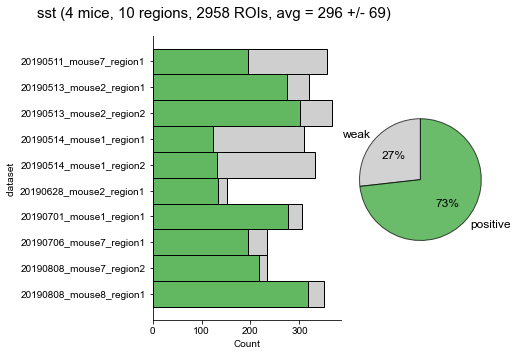

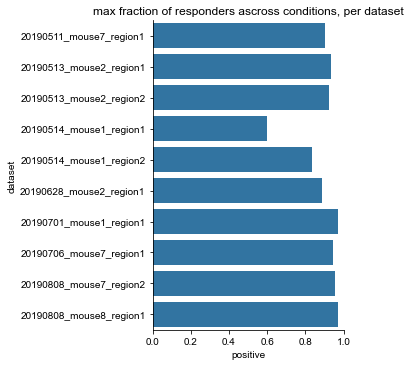

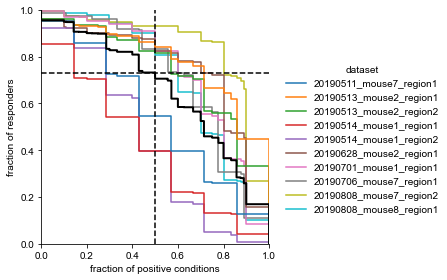

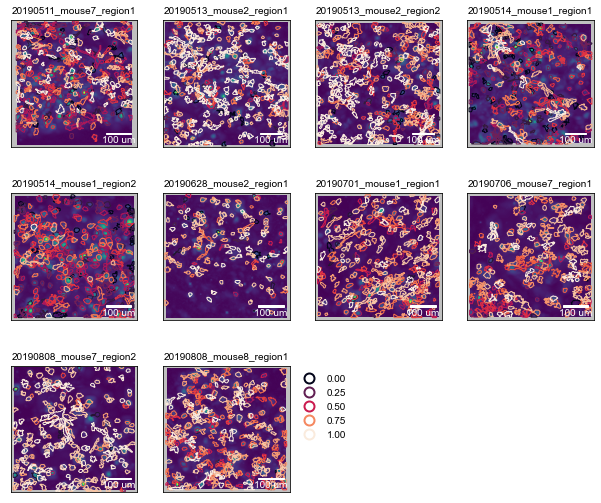

In [17]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue='positive')

 25/05/2023 16:52:14: dataset: 20190511_mouse7_region1
 25/05/2023 16:52:14: Computing average response scores over 6-by-6 grid
 25/05/2023 16:52:14: defining unstructured cubic interpolator from 24/25 grid points
 25/05/2023 16:52:14: applying interpolator over 256-by-256 evaluation grid
 25/05/2023 16:52:14: dataset: 20190513_mouse2_region1
 25/05/2023 16:52:14: Computing average response scores over 6-by-6 grid
 25/05/2023 16:52:14: applying cubic interpolation over 256-by-256 evaluation grid
 25/05/2023 16:52:14: dataset: 20190513_mouse2_region2
 25/05/2023 16:52:14: Computing average response scores over 6-by-6 grid
 25/05/2023 16:52:14: applying cubic interpolation over 256-by-256 evaluation grid
 25/05/2023 16:52:14: dataset: 20190514_mouse1_region1
 25/05/2023 16:52:14: Computing average response scores over 6-by-6 grid
 25/05/2023 16:52:14: applying cubic interpolation over 256-by-256 evaluation grid
 25/05/2023 16:52:14: dataset: 20190514_mouse1_region2
 25/05/2023 16:52:14: 

/Users/tlemaire/Documents/code/usnm2p/plotters.py:1795: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1795: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1795: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1795: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1795: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')


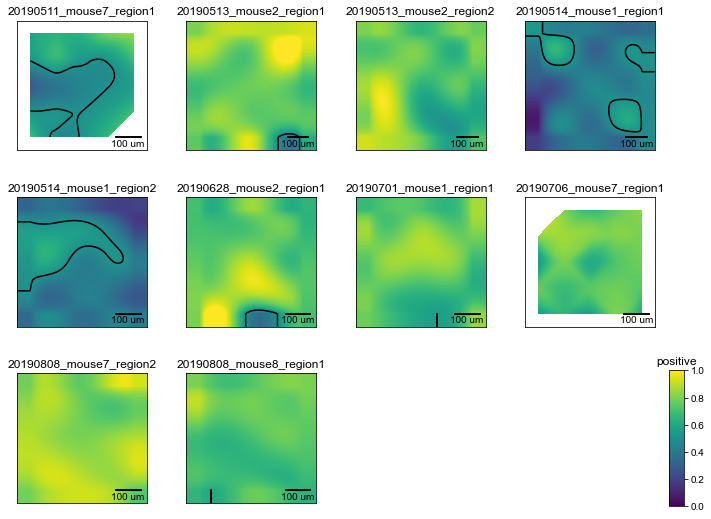

In [18]:
figs['response maps']= plot_response_map(
    ROI_masks, trialagg_stats, map_ops, 
    fs=12,
    interp_method='cubic',
    # mark_ROIs=True
)

### Plot ROI / neuropil fluorescence ratio

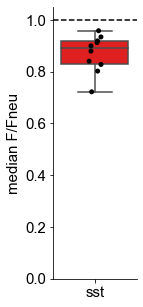

In [19]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

### Inspect dynamics of population-averaged activity

In [20]:
%%skip $isnotpv

# Define output metrics
ykey = Label.DFF

# Define frequency band for neural oscillations of interest
fband_osc = [0.05, .32]  # Hz
fkind = 'stop'

# fig, ax = plt.subplots(figsize=(10, 4))
# sns.despine(ax=ax)
# ax.axvline(FrameIndex.STIM, ls='--', c='k')
# sns.lineplot(
#     ax=ax, 
#     data=popagg_timeseries,
#     x=Label.FRAME,
#     y=ykey,
#     label='original',
#     ci=None,
#     color='k',
# )

filtered_key = f'filtered {ykey}'
# flows = [.01] 
flows = np.linspace(.01, .09, 20).round(3)
# fhighs = [.5]
fhighs = np.linspace(.2, .7, 20).round(3)
out = pd.Series(
    index=pd.MultiIndex.from_product([flows, fhighs], names=['flow (Hz)', 'fhigh (Hz)']),
    dtype=float
)

# colors = list(plt.get_cmap('tab20c').colors)[4:]
# del colors[3::4]
counter = 0 
for flow in flows:
    for fhigh in fhighs:
        # Define BW filter and plot its frequency response
        fband_osc = [flow, fhigh]
        sos, filterfunc = get_butter_filter_func(fps, fband_osc, kind=fkind)
        # figs['butter filter'] = plot_filter_frequency_response(sos, fs=fps, fc=fband_osc)

        # Apply filter to population-averaged data, per dataset and run
        logger.info(f'filtering {ykey} data...')
        popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
            .groupby([Label.DATASET, Label.RUN])
            .apply(filterfunc)
        )

        out.loc[flow, fhigh] = compute_evoked_change(popagg_timeseries, filtered_key).mean()

        # sns.lineplot(
        #     ax=ax, 
        #     data=popagg_timeseries,
        #     x=Label.FRAME,
        #     y=filtered_key,
        #     label='[' + ', '.join([f'{x:.2f}' for x in fband_osc]) + '] Hz',
        #     ci=None,
        #     color=colors[counter]
        # )
        counter += 1
# sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

sns.heatmap(
    out.unstack().T,
    center=0
)
flow_opt, fhigh_opt = out.idxmax() 
idxlow = np.where(flows == flow_opt)[0][0]
idxhigh = np.where(fhighs == fhigh_opt)[0][0]
ax.scatter([idxlow], [idxhigh], c='r', zorder=20)
ax.set_title(get_change_key(Label.DFF))

In [21]:
%%skip $isnotpv

# Define frequency band for neural oscillations of interest
fband_osc = [0.05, .32]  # Hz
fkind = 'stop'

# Apply filter to population-averaged data, per dataset and run
logger.info(f'filtering {ykey} data...')
popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
    .groupby([Label.DATASET, Label.RUN])
    .apply(filterfunc)
)

ykeys = [ykey, filtered_key]
tmp1 = compute_evoked_change(popagg_timeseries, ykey)
tmp2 = compute_evoked_change(popagg_timeseries, filtered_key)
tmp = pd.concat([compute_evoked_change(popagg_timeseries, yk) for yk in ykeys], axis=1)
tmp = free_expand_and_add(get_params_by_run(trialagg_stats), tmp)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.despine(fig=fig)
for yk, axrow in zip(ykeys, axes):
    for xkey, ax in zip([Label.P, Label.DC], axrow):
        for hue in [Label.DATASET, None]:
            sns.lineplot(
                ax=ax,
                data=get_xdep_data(tmp, xkey),
                x=xkey,
                y=get_change_key(yk),
                hue=hue,
                legend=xkey==Label.DC,
                ci=None,
                color='k' if hue is None else None,
                lw=3 if hue is None else None, 
            )
        ax.axhline(0, ls='--', c='k')
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
harmonize_axes_limits(axes.ravel())

# # fig = plot_parameter_dependency(
# #     data=tmp, xkey=Label.P, ykey=filtered_key)

In [22]:
%%skip $isnotpv

# Extract frame rate and trial-repetition frequency
fps = get_singleton(trialagg_stats, Label.FPS)
ISI = (NFRAMES_PER_TRIAL - 1) / fps  # inter-sonication interval
ftrial = 1 / ISI
logger.info(f'inter-sonication interval = {ISI:.2f} s, i.e. trial repetition frequency = {ftrial:.2f} Hz')

# Define plotting options
fmax = .55  # upper frequency limit for specturm graphs

# Plot timecourses and frequency spectra across runs, for original and filtered data
nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
figs[f'popagg {ykey} metrics'], axes = plt.subplots(
    nrows, 2, figsize=(15, 7 * nrows), 
    gridspec_kw=dict(width_ratios=(1, .2))
)
ykeys = [ykey]
groups = popagg_timeseries.groupby(Label.DATASET)
logger.setLevel(logging.WARNING)
for axrow, (dadaset_id, gdata) in tqdm(zip(axes, groups)):
    mydata = gdata.reset_index(level=Label.DATASET, drop=True)
    plot_popagg_timecourse(
        mydata, ykeys, fps, ax=axrow[0], legend=False)
    plot_popagg_frequency_spectrum(
        mydata, ykeys, fps, fmax=fmax, ax=axrow[1],
        # fband=fband_osc, fband_color={'stop': 'r', 'pass': 'g'}[fkind], 
    )
    sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
    axrow[0].set_title(dadaset_id.replace('_', ' '))
logger.setLevel(logging.INFO)
figs[f'popagg {ykey} metrics'].subplots_adjust(hspace=0.3)

### Extract oscillation phase

In [23]:
%%skip $isnotpv

fig, ax = plt.subplots()
sns.despine(ax=ax)
ax.axvline(FrameIndex.STIM, ls='--', c='k')
for yk in [ykey, filtered_key]:
    sns.lineplot(
        ax=ax, 
        data=popagg_timeseries,
        x=Label.FRAME,
        y=yk,
        ci=None
    )

In [24]:
%%skip $isnotpv

from scipy.signal import hilbert
def myfunc(s):
    h = hilbert(s)
    return pd.DataFrame({
        'A': np.abs(h),
        'phi': np.unwrap(np.angle(h))
    }, index=s.index)

tmp = (popagg_timeseries[filtered_key]
    .groupby([Label.DATASET, Label.RUN])
    .apply(myfunc)
)
fig = plot_popagg_timecourse(
    tmp, 'phi', fps, legend=False)

### Examine variability of responses

In [25]:
%%skip True
# Get fraction of responders for each dataset, run & trial
ext_resp_props = get_responders_counts(
    ext_stats, Label.RUN, units=[Label.DATASET, Label.TRIAL], normalize=True)

# Plot distirbution of responder fraction across datasets & trial, per condition
sns.catplot(
    data=ext_resp_props.reset_index(Label.RUN),
    kind='box',
    y='positive',
    x=Label.RUN,
    height=4,
    aspect=2
)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# testdata = ext_resp_props['positive']
testdata = ext_stats[ykey_diff]
testgroupby = [Label.RUN, Label.DATASET]
pthr = PTHR_DETECTION

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'tests on {testdata.name} distributions')
sns.despine(fig=fig)
histkwargs = dict(
    x='pval',
    bins=np.linspace(0, 1, 21),
    stat='density',
    hue='H0'
)
# Test if distributions are normal
from scipy.stats import normaltest
isnormal = apply_test(
    testdata, testgroupby, normaltest, pthr=pthr)
axes[0].set_title('normal test (H0: normal)')
sns.histplot(
    ax=axes[0],
    data=isnormal,
    **histkwargs
)

# Test if distributions are multimodal
from diptest import diptest
ismultimodal = apply_test(
    testdata, testgroupby, diptest, pthr=pthr)
axes[1].set_title('dip test (H0: unimodal)')
sns.histplot(
    ax=axes[1],
    data=ismultimodal,
    **histkwargs
)

In [26]:
%%skip True
# For each dataset, compute 2-way ANOVA for trial vs. ROI
Ftable = ext_stats[ykey_diff].groupby(Label.DATASET).agg(compute_ROI_vs_trial_anova)
Ftable = pd.DataFrame(
    Ftable.tolist(),
    columns=[f'F({Label.TRIAL})', f'F({Label.ROI})'],
    index=Ftable.index
)
# Plot resulting F-scores on 2D scatter graph
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=Ftable,
    x=f'F({Label.TRIAL})',
    y=f'F({Label.ROI})',
    ax=ax
)
xymax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(0, xymax)
ax.set_ylim(0, xymax)
ax.axline((0, 0), (1, 1), ls='--', color='k')
ax.set_aspect(1.)

### Plot trial heatmap per condition for entire mouse line

In [27]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Plot response traces

In [28]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

## Exports

### Save responder-type-averaged stats to disk

In [29]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

 25/05/2023 16:52:16: run not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 16:52:16: run not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 16:52:16: run not part of (P (MPa), DC (%)) -> no filtering
 25/05/2023 16:52:16: computing ROI-weighted average of (10 datasets x 797 ROIs x 15 runs) dataframe across run...
 25/05/2023 16:52:16: computing ROI-weighted average of (10 datasets x 797 ROIs x 15 runs) dataframe across run...
 25/05/2023 16:52:16: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmean_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/sst_intra.csv...
 25/05/2023 16:52:16: computing ROI-weighted average of (10 datasets x 797 ROIs x 15 runs) dataframe across run...
 25/05/2023 16:52:16: computing ROI-weighted average of (10 datasets x 797 ROIs x 15 runs) dataframe across run...
 25/05/2023 16:52:16: saving line-aggregated stats to /Users/tlem

### Save figures

In [30]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 25/05/2023 16:52:16: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.05.25/figs_main_sst_k0.5_alpha0.7_qadaptive_wq10.0s_aggmean_classzscore_directional.pdf:


100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


### Notify upon completion

In [31]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 25/05/2023 16:52:51: sst batch notebook completed in 0:01:38.507071 s
